In [1]:
%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = 'retina'
import sys
sys.path.append('.venv/lib/python3.7/site-packages/')

In [2]:
import torch
import torch.nn as nn
import torchvision
from callback.logging import TensorBoardLogger
from callback import TDVAEVisualization, ProgressCheck, ModelSaver
from common.transformation import RolloutImage
from model import TDVAE
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from common import set_random_seed
from runner import ModelRunner

In [3]:
# Load MNIST dataset. We will use the training data only because our task so far is to evaluate rollout not to 
# classify the numbers
training_set = torchvision.datasets.MNIST('data/', 
                                          train=True, 
                                          download=True, 
                                          transform=torchvision.transforms.Compose([
                                              torchvision.transforms.ToTensor(),
                                              RolloutImage(time_steps=20, offset=1),
                                              torchvision.transforms.Lambda(lambda x: torch.flatten(x, start_dim=1))
                                          ]))
                                            

In [151]:
# Preserving the original parameters given in the paper
set_random_seed(42)
model = TDVAE(belief_size=50, 
              latent_size=8, 
              d_map_size=50,
              obs_size=28*28,
              minified_obs_size=28*28,
              decoder_activation='tanh',
              decoder_hidden_dims=[200, 200],
              pre_processing_activation='relu',
              pre_processing_hidden_dims=[28*28],
              max_time_diff=4,
             num_layers=2)

optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)

In [152]:
# Define what we want to log
loss_logger = TensorBoardLogger(out_dir='board', 
                                update_frequency_type='batch', 
                                update_frequency=1)

img_logger = TensorBoardLogger(id=loss_logger.id,
                               out_dir='board', 
                               update_frequency_type='batch', 
                               update_frequency=400)

training_visualization = TDVAEVisualization(model=model, 
                                            logger=img_logger,
                                            data_set=training_set, 
                                            batch_size=10,
                                            context_size=15,
                                            rollout_size=5)

progress_check = ProgressCheck(display_measures={"total_loss", "kl_smoothing_loss", "kl_prediction_loss", "reconstruction_loss", "bce_optimal_loss"},
                               update_frequency_type='batch',
                               update_frequency=50,
                               precision=10)

model_saver = ModelSaver(model=model,
                         optimizer=optimizer,
                         out_dir=loss_logger.board_dir, 
                         update_frequency_type='epoch',
                         update_frequency=1)

callbacks = [loss_logger, training_visualization, progress_check, model_saver]

In [153]:
set_random_seed(42)
runner = ModelRunner(model, optimizer)
# runner.load(loss_logger.board_dir, 3)
# progress_check = ProgressCheck(display_measures={"total_loss", "kl_smoothing_loss", "kl_prediction_loss", "reconstruction_loss", "bce_optimal_loss"},
#                                update_frequency_type='batch',
#                                update_frequency=1,
#                                precision=10)
runner.train(training_set=training_set,
             epochs=40,
             batch_size=64,             
             callbacks=[loss_logger, progress_check, model_saver, training_visualization])

[Epoch 0 Batch 0] kl_smoothing_loss: 0.2669084668 kl_prediction_loss: 0.3076253831 bce_optimal_loss: 45.7733917236 reconstruction_loss: 499.9214477539 total_loss: 500.4959716797
[Epoch 0 Batch 50] kl_smoothing_loss: 0.4106174111 kl_prediction_loss: 2.9773302078 bce_optimal_loss: 43.7320480347 reconstruction_loss: 212.2524414062 total_loss: 215.6403961182
[Epoch 0 Batch 100] kl_smoothing_loss: 0.0889563933 kl_prediction_loss: 0.5522131920 bce_optimal_loss: 45.7588310242 reconstruction_loss: 218.9468231201 total_loss: 219.5879974365
[Epoch 0 Batch 150] kl_smoothing_loss: 0.1090393960 kl_prediction_loss: 0.3339487910 bce_optimal_loss: 43.5413703918 reconstruction_loss: 211.3759002686 total_loss: 211.8188934326
[Epoch 0 Batch 200] kl_smoothing_loss: 0.1546809673 kl_prediction_loss: 0.1559520364 bce_optimal_loss: 43.9086608887 reconstruction_loss: 196.0219268799 total_loss: 196.3325653076
[Epoch 0 Batch 250] kl_smoothing_loss: 0.1729292721 kl_prediction_loss: 0.1947341561 bce_optimal_loss: 

KeyboardInterrupt: 

yes
[Epoch 1 Batch 0] kl_smoothing_loss: 0.8076688647 kl_prediction_loss: 1.0323816538 bce_optimal_loss: 45.3717842102 reconstruction_loss: 151.9530792236 total_loss: 153.7931365967


KeyboardInterrupt: 

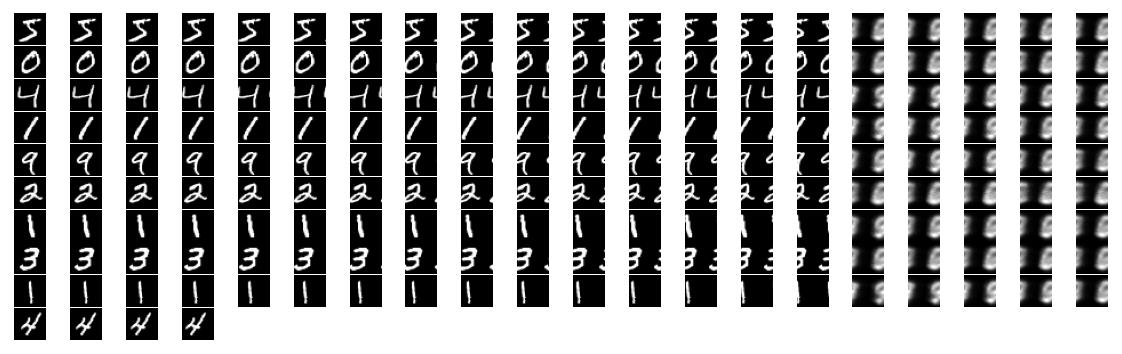

In [159]:
runner = ModelRunner(model, optimizer)
runner.load(loss_logger.board_dir, 0)
set_random_seed(42)
runner.train(training_set=training_set,
             epochs=40,
             batch_size=64,             
             callbacks=[loss_logger, progress_check, training_visualization])

In [34]:
set_random_seed(42)
runner = ModelRunner(model)
runner.train(training_set=training_set,
             epochs=40,
             batch_size=64,
             optimizer=torch.optim.Adam(model.parameters(), lr=0.0005),
             callbacks=[loss_logger, progress_check, training_visualization])

Belief
tensor([[ 0.0556,  0.0079,  0.0586,  0.0207,  0.0089, -0.0020,  0.0186,  0.0201,
          0.1043,  0.0856,  0.0345, -0.0255, -0.0083,  0.0330, -0.0471, -0.0248,
         -0.0055, -0.0247, -0.0053, -0.0396, -0.0082,  0.0047,  0.0325, -0.0098,
         -0.1134, -0.0716,  0.0223, -0.0402,  0.0813, -0.0773,  0.0641,  0.0178,
          0.0389,  0.0474, -0.0738,  0.0876,  0.0362,  0.0156,  0.0719,  0.0264,
         -0.0447,  0.0180, -0.0253, -0.0072, -0.0456, -0.0321, -0.0814,  0.0073,
         -0.0302, -0.0401],
        [-0.0433, -0.0296, -0.0565,  0.0425,  0.0283,  0.0217,  0.0502, -0.0635,
         -0.0147, -0.0108,  0.0461, -0.0382,  0.0382, -0.0284,  0.0356,  0.0940,
         -0.0302,  0.0620,  0.0418,  0.0679, -0.0293, -0.0636, -0.0413,  0.0078,
          0.0482,  0.0004,  0.0503, -0.0115,  0.0653, -0.0142,  0.0781,  0.0131,
         -0.0630,  0.0919,  0.0572, -0.0765, -0.0318, -0.0068,  0.0368,  0.0145,
         -0.0326,  0.0562,  0.0607, -0.0372, -0.0547,  0.0730,  0.0351,  0

[Epoch 0 Batch 50] kl_t1_loss: 0.4106174111 kl_t2_loss: 2.9773302078 bce_optimal_loss: 43.7320480347 x_loss: 212.2524414062 total_loss: 215.6403961182
[Epoch 0 Batch 100] kl_t1_loss: 0.0889563933 kl_t2_loss: 0.5522131920 bce_optimal_loss: 45.7588310242 x_loss: 218.9468231201 total_loss: 219.5879974365
[Epoch 0 Batch 150] kl_t1_loss: 0.1090393960 kl_t2_loss: 0.3339487910 bce_optimal_loss: 43.5413703918 x_loss: 211.3759002686 total_loss: 211.8188934326
[Epoch 0 Batch 200] kl_t1_loss: 0.1546809673 kl_t2_loss: 0.1559520364 bce_optimal_loss: 43.9086608887 x_loss: 196.0219268799 total_loss: 196.3325653076
[Epoch 0 Batch 250] kl_t1_loss: 0.1729292721 kl_t2_loss: 0.1947341561 bce_optimal_loss: 43.8976745605 x_loss: 209.9935607910 total_loss: 210.3612213135
[Epoch 0 Batch 300] kl_t1_loss: 0.2082721591 kl_t2_loss: 0.3375595212 bce_optimal_loss: 48.6030769348 x_loss: 232.4229583740 total_loss: 232.9687957764
[Epoch 0 Batch 350] kl_t1_loss: 0.2277400643 kl_t2_loss: 0.7256560922 bce_optimal_loss: 4

[Epoch 2 Batch 850] kl_t1_loss: 0.5796257854 kl_t2_loss: 1.2556267977 bce_optimal_loss: 43.4740295410 x_loss: 133.7267456055 total_loss: 135.5619964600
[Epoch 2 Batch 900] kl_t1_loss: 0.7691668868 kl_t2_loss: 1.3874654770 bce_optimal_loss: 46.1790122986 x_loss: 137.5632324219 total_loss: 139.7198638916
[Epoch 3 Batch 0] kl_t1_loss: 0.6172403097 kl_t2_loss: 1.6605403423 bce_optimal_loss: 45.7733955383 x_loss: 135.2759857178 total_loss: 137.5537719727
[Epoch 3 Batch 50] kl_t1_loss: 0.6159579754 kl_t2_loss: 1.0145348310 bce_optimal_loss: 43.7320480347 x_loss: 124.9279708862 total_loss: 126.5584640503
[Epoch 3 Batch 100] kl_t1_loss: 0.6829426289 kl_t2_loss: 1.3491761684 bce_optimal_loss: 45.7588310242 x_loss: 142.1090850830 total_loss: 144.1412048340
[Epoch 3 Batch 150] kl_t1_loss: 0.5911455154 kl_t2_loss: 1.5386680365 bce_optimal_loss: 43.5413703918 x_loss: 148.7204742432 total_loss: 150.8502807617
[Epoch 3 Batch 200] kl_t1_loss: 0.6077427864 kl_t2_loss: 1.9074091911 bce_optimal_loss: 43.

[Epoch 5 Batch 700] kl_t1_loss: 0.5222356319 kl_t2_loss: 1.5168744326 bce_optimal_loss: 45.5227928162 x_loss: 130.2024688721 total_loss: 132.2415771484
[Epoch 5 Batch 750] kl_t1_loss: 0.5044545531 kl_t2_loss: 1.6127461195 bce_optimal_loss: 46.1368560791 x_loss: 139.9421234131 total_loss: 142.0593261719
[Epoch 5 Batch 800] kl_t1_loss: 0.5805746913 kl_t2_loss: 1.5484839678 bce_optimal_loss: 46.2337722778 x_loss: 146.8550720215 total_loss: 148.9841308594
[Epoch 5 Batch 850] kl_t1_loss: 0.5844429135 kl_t2_loss: 1.4558627605 bce_optimal_loss: 43.4740295410 x_loss: 125.0089721680 total_loss: 127.0492782593
[Epoch 5 Batch 900] kl_t1_loss: 0.5732424259 kl_t2_loss: 1.6898632050 bce_optimal_loss: 46.1790084839 x_loss: 128.4930114746 total_loss: 130.7561187744
[Epoch 6 Batch 0] kl_t1_loss: 0.5860720277 kl_t2_loss: 1.6056425571 bce_optimal_loss: 45.7733917236 x_loss: 127.9745788574 total_loss: 130.1662902832
[Epoch 6 Batch 50] kl_t1_loss: 0.7136358023 kl_t2_loss: 1.4980826378 bce_optimal_loss: 43.

KeyboardInterrupt: 

In [ ]:
set_random_seed(42)
runner = ModelRunner(model)
runner.train(training_set=training_set,
             epochs=40,
             batch_size=64,
             optimizer=torch.optim.Adam(model.parameters(), lr=0.0005),
             callbacks=[progress_check])

In [ ]:
test = training_set.data[:5].clone().detach() / 255.
rollout = RolloutImage(10, 2)
imgs = []
for i in range(test.size(0)): 
    img = rollout(torch.unsqueeze(test[i], dim=0))
    img = torch.flatten(img, start_dim=1)
    imgs.append(img)
test = torch.stack(imgs, dim=0)    

In [ ]:
fig = plt.figure(0, figsize = (10,3))
fig.clf()
gs = gridspec.GridSpec(test.size(0),test.size(1))
gs.update(wspace = 0.025, hspace = 0.025)

for i in range(test.size(0)):
    img = test[i]
    for n in range(test.size(1)):
        axes = plt.subplot(gs[i,n])
        axes.imshow(img[n,:].reshape(28,28), cmap = 'gray')
        axes.axis('off')
plt.show()

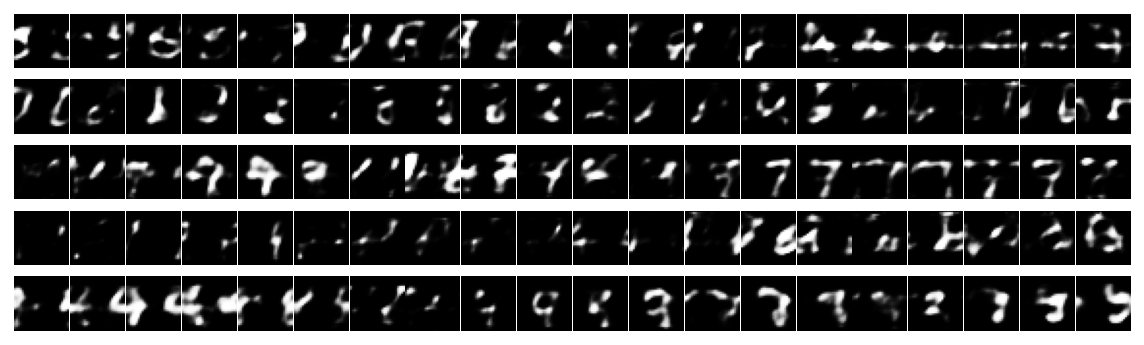

In [9]:
future = model.rollout(test, 20)
fig = plt.figure(0, figsize = (10,3))
fig.clf()
gs = gridspec.GridSpec(future.size(0),future.size(1))
gs.update(wspace = 0.025, hspace = 0.025)

for i in range(future.size(0)):
    img = future[i]
    for n in range(future.size(1)):
        axes = plt.subplot(gs[i,n])
        axes.imshow(img[n,:].reshape(28,28), cmap = 'gray')
        axes.axis('off')
plt.show()

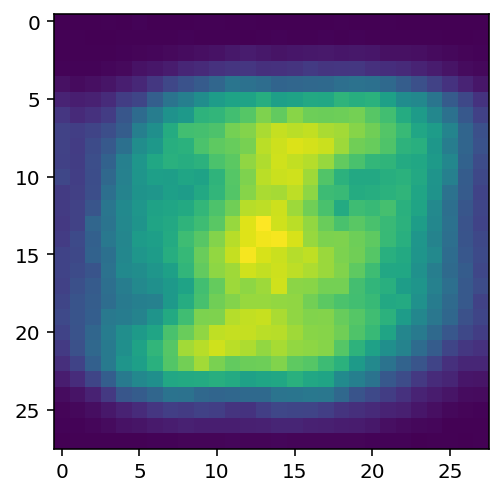

In [16]:
plt.imshow(future[0][0].reshape(28,28))

In [30]:
test[0][0]

tensor([0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
        0.0000, 0.0000, 0.0000, 0.0000, 

In [24]:
from common import calculate_gaussian_kl_divergence
mu_q = torch.tensor([[2]])
log_var_q = torch.log(torch.tensor([[3]]))
mu_p = torch.tensor([[4]])
log_var_p = torch.log(torch.tensor([[5]]))
calculate_gaussian_kl_divergence([mu_q, log_var_q], [mu_p, log_var_p])

tensor([0.2708])

In [25]:
q = torch.distributions.normal.Normal(mu_q, torch.exp(log_var_q))
p = torch.distributions.normal.Normal(mu_p, torch.exp(log_var_p))
torch.distributions.kl.kl_divergence(q, p)

tensor([[0.2708]])

In [16]:
import torch.nn.functional as F
input_ = torch.sigmoid(torch.randn((3, 2), requires_grad=True))
target = torch.rand((3, 2), requires_grad=False)
loss = F.binary_cross_entropy(input_, target)

In [17]:
loss

tensor(0.9234, grad_fn=<BinaryCrossEntropyBackward0>)

In [18]:
input_

tensor([[0.2470, 0.5913],
        [0.2988, 0.5012],
        [0.6072, 0.7429]], grad_fn=<SigmoidBackward0>)

In [19]:
target

tensor([[0.9518, 0.4647],
        [0.8742, 0.1464],
        [0.7429, 0.2749]])

In [20]:
bce = -(target * torch.log(input_) + (1 - target) * torch.log(1 - input_))
bce

tensor([[1.3446, 0.7231],
        [1.1006, 0.6948],
        [0.6109, 1.0667]], grad_fn=<NegBackward0>)

In [21]:
torch.sum(bce, dim=1)

tensor([2.0677, 1.7954, 1.6776], grad_fn=<SumBackward1>)

In [22]:
import numpy as np
np.random.choice([18])

18

In [23]:
idx = torch.tensor([0,2,2])
target[idx, :]

tensor([[0.9518, 0.4647],
        [0.7429, 0.2749],
        [0.7429, 0.2749]])

In [29]:
torch.gather(target, 1, idx)

RuntimeError: Index tensor must have the same number of dimensions as input tensor

In [32]:
target[..., None].expand(-1, -1, 1)

tensor([[[0.9518],
         [0.4647]],

        [[0.8742],
         [0.1464]],

        [[0.7429],
         [0.2749]]])

In [41]:
idx[..., None].expand(3, 4)

tensor([[0, 0, 0, 0],
        [2, 2, 2, 2],
        [2, 2, 2, 2]])

In [49]:
bs = torch.tensor([[[[[1,2,3,4], [5,6,7,8]]], [[[9,10,11,12], [13,14,15,16]]], [[[17,18,19,20], [21,22,23,24]]], [[[25,26,27,28], [29,30,31,32]]], [[[33,34,35,36], [37,38,39,40]]]], [[[[41,42,43,44], [45,46,47,48]]], [[[49,50,51,52], [53,54,55,56]]], [[[57,58,59,60], [61,62,63,64]]], [[[65,66,67,68], [60,70,71,72]]], [[[73,74,75,76], [77,78,79,80]]]], [[[[81,82,83,84], [85,86,87,88]]], [[[89,90,91,92], [93,94,95,96]]], [[[1,2,3,4], [5,6,7,8]]], [[[97,98,99,100], [101,102,103,104]]], [[[105,106,107,108], [109,110,111,112]]]]])[:, :, 0, :, :]
bs.shape

torch.Size([3, 5, 2, 4])

In [51]:
idx = torch.tensor([3, 2, 1])
idx_exp = idx[..., None, None, None].expand(-1, -1, bs.size(2), bs.size(3))
bs_t1 = torch.gather(bs, 1, idx_exp).view(-1, bs.size(2), bs.size(3))

In [52]:
idx_exp

tensor([[[[3, 3, 3, 3],
          [3, 3, 3, 3]]],


        [[[2, 2, 2, 2],
          [2, 2, 2, 2]]],


        [[[1, 1, 1, 1],
          [1, 1, 1, 1]]]])

In [56]:
bs_t1

tensor([[[25, 26, 27, 28],
         [29, 30, 31, 32]],

        [[57, 58, 59, 60],
         [61, 62, 63, 64]],

        [[89, 90, 91, 92],
         [93, 94, 95, 96]]])

In [54]:
bs

tensor([[[[  1,   2,   3,   4],
          [  5,   6,   7,   8]],

         [[  9,  10,  11,  12],
          [ 13,  14,  15,  16]],

         [[ 17,  18,  19,  20],
          [ 21,  22,  23,  24]],

         [[ 25,  26,  27,  28],
          [ 29,  30,  31,  32]],

         [[ 33,  34,  35,  36],
          [ 37,  38,  39,  40]]],


        [[[ 41,  42,  43,  44],
          [ 45,  46,  47,  48]],

         [[ 49,  50,  51,  52],
          [ 53,  54,  55,  56]],

         [[ 57,  58,  59,  60],
          [ 61,  62,  63,  64]],

         [[ 65,  66,  67,  68],
          [ 60,  70,  71,  72]],

         [[ 73,  74,  75,  76],
          [ 77,  78,  79,  80]]],


        [[[ 81,  82,  83,  84],
          [ 85,  86,  87,  88]],

         [[ 89,  90,  91,  92],
          [ 93,  94,  95,  96]],

         [[  1,   2,   3,   4],
          [  5,   6,   7,   8]],

         [[ 97,  98,  99, 100],
          [101, 102, 103, 104]],

         [[105, 106, 107, 108],
          [109, 110, 111, 112]]]])

In [7]:
t1 = torch.load('t2.pt')
t2 = torch.load('t2_other.pt')

In [8]:
t1

tensor([12,  4,  4,  5, 13, 10,  7,  5, 13,  4,  3,  6, 16, 15, 14,  7,  5, 13,
        11,  7, 13,  5,  4,  3, 18, 14, 11,  6,  6,  2, 13,  6, 13,  6, 11, 10,
         7,  8,  3, 16,  6, 15,  3, 10,  7,  6,  5,  2, 14, 13, 13, 15,  4,  4,
         2,  6,  4, 11, 15, 15, 10, 12,  2,  7])

In [9]:
t2

tensor([[12,  4,  4,  5, 13, 10,  7,  5, 13,  4,  3,  6, 16, 15, 14,  7,  5, 13,
         11,  7, 13,  5,  4,  3, 18, 14, 11,  6,  6,  2, 13,  6, 13,  6, 11, 10,
          7,  8,  3, 16,  6, 15,  3, 10,  7,  6,  5,  2, 14, 13, 13, 15,  4,  4,
          2,  6,  4, 11, 15, 15, 10, 12,  2,  7]])

In [11]:
x1 = torch.load('true_x_t2.pt')
x2 = torch.load('true_x_t2_other.pt')

In [12]:
print(x1.shape)
print(x2.shape)

torch.Size([64, 784])
torch.Size([64, 784])


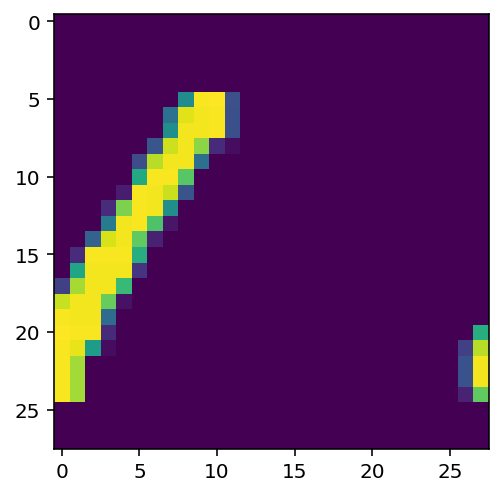

In [13]:
plt.imshow(x1[3].reshape(28, 28))

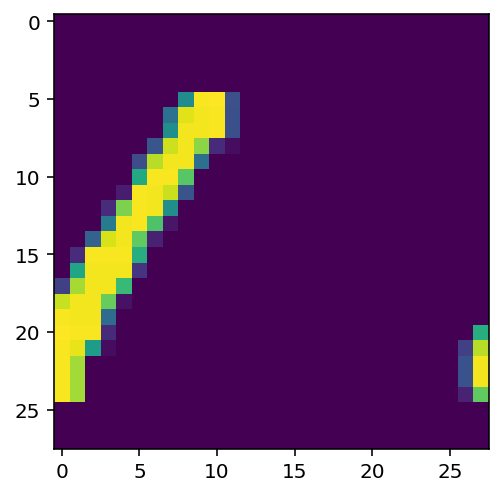

In [14]:
plt.imshow(x2[3].reshape(28, 28))

In [15]:
(x1 == x2).all()

tensor(True)

In [74]:
import torch
from torch.autograd import Variable

In [111]:
x1 = Variable(torch.tensor([[0.5], [0.4]]), requires_grad=True)
x2 = Variable(torch.tensor([[0.1], [0.8]]), requires_grad=True)
target = Variable(torch.tensor([[0.2, 0.4], [0.6, 0.9]]))
z = torch.cat([x1, x2], dim=1)

loss = torch.mean(torch.exp(z) - target)
loss.backward()
                  
print(loss)
print(x1.grad)
print(x2.grad)

tensor(1.0928, grad_fn=<MeanBackward0>)
tensor([[0.4122],
        [0.3730]])
tensor([[0.2763],
        [0.5564]])


In [136]:
x1 = Variable(torch.tensor([[0.5], [0.4]]), requires_grad=True)
x2 = Variable(torch.tensor([[0.1], [0.8]]), requires_grad=True)
target = Variable(torch.tensor([[0.2, 0.4], [0.6, 0.9]]))
z = torch.cat([x1, x2], dim=1)

kl1 = torch.exp(z)
kl2 = torch.pow(z, 2)

loss = torch.mean(kl1 + kl2 - target)
loss.backward()
                  
print(loss)
print(x1.grad)
print(x2.grad)

tensor(1.3578, grad_fn=<MeanBackward0>)
tensor([[0.6622],
        [0.5730]])
tensor([[0.3263],
        [0.9564]])


In [140]:
x1 = Variable(torch.tensor([[0.5], [0.4]]), requires_grad=True)
x2 = Variable(torch.tensor([[0.1], [0.8]]), requires_grad=True)
target = Variable(torch.tensor([[0.2, 0.4], [0.6, 0.9]]))
z = torch.cat([x1, x2], dim=1)
z2 = torch.cat([x1, x2], dim=1)

kl1 = torch.exp(z)
kl2 = torch.pow(z2, 2)

loss = torch.mean(kl1 + kl2 - target)
loss.backward()
                  
print(loss)
print(x1.grad)
print(x2.grad)

tensor(1.3578, grad_fn=<MeanBackward0>)
tensor([[0.6622],
        [0.5730]])
tensor([[0.3263],
        [0.9564]])


In [83]:
z = torch.cat([x1, x2], dim=1)
z2 = torch.cat([x1, x2], dim=1)

kl1 = torch.exp(z)
kl2 = torch.pow(z2, 2)

loss = torch.mean((kl1 + kl2) - target)
loss.backward()

In [84]:
print(loss)
print(x1.grad)
print(x2.grad)

tensor(2.2546, grad_fn=<MeanBackward0>)
tensor([[2.0367],
        [1.0146],
        [0.8148]])
tensor([[0.2160],
        [0.3567],
        [0.4929]])


In [103]:
z = torch.cat([x1, x2], dim=1)
# z2 = torch.cat([x1, x2], dim=1)

kl1 = torch.exp(x1)
kl2 = torch.pow(z, 2)

loss = torch.sum(kl1 - target)
loss.backward()

In [104]:
print(loss)
print(x1.grad)
# print(x2.grad)

tensor(15.8113, grad_fn=<SumBackward0>)
tensor([[40.8284],
        [14.8545],
        [11.8737]])


In [113]:
2*x1*(1 + torch.exp(x1))/2

tensor([[1.3244],
        [0.9967]], grad_fn=<DivBackward0>)

In [88]:
kl1

tensor([[4.1798, 0.6223],
        [1.9013, 0.7970],
        [1.5235, 0.9894]], grad_fn=<ExpBackward0>)

In [89]:
kl2

tensor([[2.0457e+00, 2.2493e-01],
        [4.1283e-01, 5.1486e-02],
        [1.7726e-01, 1.1373e-04]], grad_fn=<PowBackward0>)

In [10]:
from model import GaussianNN
from model.tdvae import DBlock

set_random_seed(42)
b1 = DBlock(10, 50, 5)

set_random_seed(42)
b2 = GaussianNN(10, 50, 5)

x = torch.randn((20, 10))

mu1, logsigma1 = b1(x)
params = b2(x)
mu2, logsigma2 = params[0], params[1]

print((mu1 == mu2).all())
print((logsigma1 == logsigma2).all())

tensor(True)
tensor(True)


In [8]:
mu1

tensor([[ 0.0658,  0.1381,  0.0873, -0.1256, -0.1050],
        [ 0.1708,  0.1933, -0.2796, -0.2399, -0.0068],
        [-0.0554,  0.0925,  0.2427,  0.0767, -0.1931],
        [-0.0351,  0.2054,  0.2734,  0.1131, -0.0536],
        [ 0.1137, -0.0048, -0.0260, -0.1588, -0.0727],
        [ 0.1592,  0.1401,  0.2458, -0.1238,  0.0813],
        [ 0.1472,  0.3494,  0.0459,  0.0365, -0.2004],
        [-0.0257,  0.1774,  0.0807,  0.0297, -0.0585],
        [-0.0436,  0.1271,  0.2442, -0.0463, -0.2081],
        [ 0.1253,  0.3233,  0.1303, -0.2096, -0.1840],
        [ 0.0429,  0.0731,  0.2956, -0.0756,  0.0018],
        [ 0.2666,  0.1131, -0.0043, -0.3356, -0.0845],
        [-0.0300,  0.0140,  0.1586, -0.2271,  0.1196],
        [ 0.0397, -0.1156, -0.0630, -0.1702, -0.1819],
        [ 0.1100,  0.2796,  0.0015,  0.1873, -0.1567],
        [ 0.0335, -0.0728, -0.0094, -0.2155, -0.1874],
        [ 0.0755,  0.1621,  0.1702,  0.0851, -0.0426],
        [ 0.0907,  0.1365, -0.0036,  0.0187, -0.3055],
        [ 

In [9]:
mu2

tensor([[-0.0209,  0.1894, -0.0022,  0.0974,  0.1030],
        [-0.0263,  0.2460, -0.1416,  0.0583,  0.3227],
        [ 0.1055, -0.0313,  0.1383,  0.0649, -0.0097],
        [ 0.0974,  0.3262, -0.0925,  0.0719, -0.1115],
        [-0.1472,  0.0579,  0.1771, -0.0193,  0.1040],
        [-0.0841,  0.1513,  0.2988, -0.1880,  0.0292],
        [ 0.0611,  0.1255,  0.0709,  0.1386, -0.1475],
        [-0.1219,  0.0383,  0.1558, -0.0591,  0.1416],
        [ 0.1064,  0.0537, -0.0818,  0.0532,  0.0699],
        [ 0.0979,  0.2647, -0.0743,  0.2479, -0.0326],
        [-0.0122,  0.2265,  0.2158, -0.0676, -0.1058],
        [-0.0447,  0.2792,  0.0876,  0.0837,  0.0581],
        [-0.1033,  0.1537,  0.3213,  0.0087,  0.0909],
        [-0.0928, -0.0783,  0.0803,  0.1477,  0.2341],
        [ 0.0421,  0.2687,  0.0112, -0.0167, -0.0848],
        [ 0.0277, -0.0223,  0.2142, -0.0068,  0.0824],
        [-0.0230,  0.4061, -0.0879,  0.1479, -0.0623],
        [ 0.1122, -0.0189,  0.0890,  0.1786, -0.0312],
        [-

In [38]:
from common import calculate_gaussian_kl_divergence
from pylego import ops
from torch.autograd import Variable

torch.set_printoptions(precision=10)

p_params = (Variable(torch.tensor([[1.], [2.], [3.]]), requires_grad=True),  Variable(torch.tensor([[0.1541236584], [0.2], [0.3]]), requires_grad=True))
q_params = (Variable(torch.tensor([[4.], [1.], [2.]]), requires_grad=True),  Variable(torch.tensor([[0.6], [0.2], [0.2]]), requires_grad=True))

kl1 = calculate_gaussian_kl_divergence(p_params, q_params).mean()
kl1.backward()

print(p_params[0].grad)
print(p_params[1].grad)
print(q_params[0].grad)
print(q_params[1].grad)

tensor([[-0.5488116145],
        [ 0.2729102671],
        [ 0.2729102671]])
tensor([[-0.0599561781],
        [ 0.0000000000],
        [ 0.0175284892]])
tensor([[ 0.5488116145],
        [-0.2729102671],
        [-0.2729102671]])
tensor([[-0.7632611990],
        [-0.1364551336],
        [-0.1539836228]])


In [39]:
p_params = (Variable(torch.tensor([[1.], [2.], [3.]]), requires_grad=True),  Variable(torch.tensor([[0.1541236584], [0.2], [0.3]]), requires_grad=True))
q_params = (Variable(torch.tensor([[4.], [1.], [2.]]), requires_grad=True),  Variable(torch.tensor([[0.6], [0.2], [0.2]]), requires_grad=True))

kl2 = ops.kl_div_gaussian(p_params[0], p_params[1], q_params[0], q_params[1]).mean()
kl2.backward()

print(p_params[0].grad)
print(p_params[1].grad)
print(q_params[0].grad)
print(q_params[1].grad)


tensor([[-0.5488116145],
        [ 0.2729102671],
        [ 0.2729102671]])
tensor([[-0.0599561781],
        [ 0.0000000000],
        [ 0.0175284892]])
tensor([[ 0.5488116145],
        [-0.2729102671],
        [-0.2729102671]])
tensor([[-0.7632611990],
        [-0.1364551336],
        [-0.1539836228]])


In [83]:
from torch.utils.data import Dataset, DataLoader, TensorDataset
from torch.utils.data.dataloader import Sampler
import random

class MySampler(Sampler):
    def __init__(self, data_size: int, batch_size: int, batch=0):
        self.seq = list(range(data_size))[batch * batch_size:]

    def __iter__(self):
        return iter(self.seq)

    def __len__(self):
        return len(self.seq)

ds = TensorDataset(torch.randn(10, 2))
ds.tensors

(tensor([[-0.0050,  0.1235],
         [ 0.9551,  0.6251],
         [-1.3055, -0.9274],
         [ 0.2877,  0.2316],
         [ 0.0751, -0.0034],
         [ 0.6895,  0.1012],
         [-0.5067,  2.4213],
         [ 0.8446, -0.7954],
         [ 0.2258, -1.6381],
         [-0.3489, -0.2428]]),)

In [94]:
random.seed(0)
sampler = MySampler(len(ds), 2, 0)
dl = DataLoader(ds, batch_size=2, sampler=sampler)
for i in [1]:
    for i, t in enumerate(dl):
        print(t)
        print(torch.randint(low=0, high=20 - 4, size=(10,)))
        if i == 1:
            break
        random_state = torch.get_rng_state()
        

[tensor([[-0.0050,  0.1235],
        [ 0.9551,  0.6251]])]
tensor([13,  8, 14,  5,  7,  9, 12, 14, 12,  3])
[tensor([[-1.3055, -0.9274],
        [ 0.2877,  0.2316]])]
tensor([ 1,  1,  8,  0, 11,  6, 15, 10, 13,  2])


In [95]:
random.seed(0)
sampler = MySampler(len(ds), 2, 1)
dl = DataLoader(ds, batch_size=2, sampler=sampler)
torch.set_rng_state(random_state)
for i in [1]:
    for t in dl:
        print(t)
        print(torch.randint(low=0, high=20 - 4, size=(10,)))
        break

[tensor([[-1.3055, -0.9274],
        [ 0.2877,  0.2316]])]
tensor([ 8,  0, 11,  6, 15, 10, 13,  2,  2,  1])


In [50]:
random.seed(0)
sampler = MySampler(len(ds), 2, 2)
dl = DataLoader(ds, batch_size=2, sampler=sampler)
for t in dl:
    print(t)

[tensor([[ 1.3704, -0.8744],
        [-1.1340,  0.1893]])]
[tensor([[-1.4790, -0.3922],
        [ 1.7689,  0.4970]])]
[tensor([[-0.4989,  0.4211],
        [-1.1898,  0.0038]])]


In [44]:
size = 64
torch.random.manual_seed(42)
t1 = torch.randint(low=0, high=20 - 4, size=(size,))
t2 = t1 + torch.randint(low=1, high=4 + 1, size=(size,))
print(t1)
print(t2)
rs = torch.get_rng_state()
t1 = torch.randint(low=0, high=20 - 4, size=(size,))
t2 = t1 + torch.randint(low=1, high=4 + 1, size=(size,))
print(t1)
print(t2)
torch.set_rng_state(rs)

tensor([ 6,  3, 12, 14, 10,  7, 12,  4,  6,  9,  2,  6, 10, 10,  7,  4,  3,  7,
         7,  2,  5,  4,  1,  7, 11, 13,  5,  1, 15, 11,  4,  0, 11,  9,  5, 12,
        11,  8,  0, 10, 10, 14,  9, 15, 11, 11, 15, 14, 13, 13, 14, 13,  2, 11,
         6,  3, 15,  8,  2,  4,  2,  6,  4,  8])
tensor([ 9,  5, 16, 15, 14,  9, 14,  6,  7, 11,  3,  8, 14, 14, 10,  8,  6, 11,
         8,  6,  8,  7,  3,  8, 15, 15,  9,  5, 17, 13,  6,  2, 13, 13,  7, 13,
        14, 10,  2, 14, 12, 16, 11, 19, 13, 14, 19, 17, 17, 15, 17, 17,  3, 13,
        10,  4, 19,  9,  4,  7,  3, 10,  6,  9])
tensor([11, 11, 11, 12,  8, 12, 14, 12,  0,  8,  6,  8,  7,  0, 11,  7,  7, 14,
        10,  2,  0,  7,  2,  2,  0, 10,  4,  9,  6,  9,  8, 11,  6,  8,  7, 11,
         1,  0, 15,  6,  6, 13,  7,  4,  2, 11,  7,  5, 10,  2,  0,  2,  4, 14,
        13,  2,  0,  4,  9,  6, 14, 13,  6, 10])
tensor([12, 14, 14, 14, 10, 16, 15, 15,  3, 12,  9,  9, 11,  1, 15, 11,  9, 15,
        13,  5,  1, 10,  5,  3,  4, 11,  8, 12,  9, 1

In [42]:

t1 = torch.randint(low=0, high=20 - 4, size=(size,))
t2 = t1 + torch.randint(low=1, high=4 + 1, size=(size,))
print(t1)
print(t2)

tensor([11, 11, 11, 12,  8, 12, 14, 12,  0,  8,  6,  8,  7,  0, 11,  7,  7, 14,
        10,  2,  0,  7,  2,  2,  0, 10,  4,  9,  6,  9,  8, 11,  6,  8,  7, 11,
         1,  0, 15,  6,  6, 13,  7,  4,  2, 11,  7,  5, 10,  2,  0,  2,  4, 14,
        13,  2,  0,  4,  9,  6, 14, 13,  6, 10])
tensor([12, 14, 14, 14, 10, 16, 15, 15,  3, 12,  9,  9, 11,  1, 15, 11,  9, 15,
        13,  5,  1, 10,  5,  3,  4, 11,  8, 12,  9, 12, 10, 15,  8, 10,  8, 13,
         2,  1, 17, 10, 10, 17, 11,  8,  4, 13, 10,  9, 12,  5,  4,  3,  7, 16,
        14,  3,  1,  7, 11,  7, 18, 14,  7, 13])


In [141]:
order = str(1).zfill(5)
out_dir = "test"
print(f"{out_dir}/model_{order}_.pt")

test/model_00001_.pt
